In [86]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import plotly.express as px
import matplotlib.pyplot as plt

# DATA

In [87]:
train_df = pd.read_csv('Train_Product_Data_2021_0114.csv',index_col=0)
train_df.head()

,string_X_train,string_Y_1,string_Y_2,Y_label,Forward,Backward,row_id,label_for_train
586,"YUNGSOX 2100M 12MT USD1,015/MT USD12,180 YUNGS...",0,13,YUNGSOX 2100M,NaN,"2MT USD1,015",855,"{'Product':[( 0 , 13 )]}"
92,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",0,50,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",CLOHEXANE DI,"OXYLIC ACID,",140,"{'Product':[( 0 , 50 )]}"
91,"TRIS . CIF PORT KLANG,MALAYSIA",0,4,TRIS,NaN,SIA,139,"{'Product':[( 0 , 4 )]}"
1000,"TRADE TERMS:CIF HEYUAN, CHINA AND/OR CIF CHANG...",73,87,PVC RESIN S-70,"NG, CHINA.1",PER MT AS PE,1425,"{'Product':[( 73 , 87 )]}"
82,TRADE TERMS INCOTERMS 2010 : CFR HAI PHONG POR...,145,166,ABS AF3535-AJ Z-BLACK,MOUNT ABS AF,-BLACK 108MT,126,"{'Product':[( 145 , 166 )]}"


In [88]:
val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0)
val_df.head()

,string_X_train,string_Y_1,string_Y_2,Y_label,Forward,Backward,row_id
1,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,NaN,"TITY: 3,000.",1
2,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,NaN,"TITY: 3,000.",2
3,PP 3307UNC1 . TRADE TERMS: CFR ANY JAPANESE PORT,0,2,PP,NaN,RADE TERMS:,10
4,"CIF BELAWAN PORT, INDONESIA +20 MT +/- 5PCT OF...",47,62,2-ETHYL HEXANOL,+/- 5PCT OF,AT USD890.0,13
5,"CIF BELAWAN PORT, INDONESIA +20 MTON +/-5PCT O...",48,63,2-ETHYL HEXANOL,+/-5PCT OF,AT USD 860/,14


In [89]:
寶典 = pd.read_excel('台塑企業_ 產品寶典20210303.xlsx')['品名']
寶典.head()

0    CAUSTIC SODA LIQUID FLAKE PEARLS MICROPEARLS
1                             CAUSTIC SODA LIQUID
2                             COMMODITY FORMOSACN
3                                      CHLOROFORM
4                             ETHYLENE DICHLORIDE
Name: 品名, dtype: object

# Analysis

115
79
0.5927835051546392


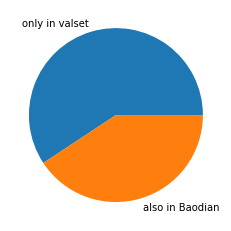

In [98]:
a = set(val_df['Y_label']) - set(寶典) #驗證集有但是寶典裡沒有的部份
b = set(val_df['Y_label']) & set(寶典) #驗證集有同時寶典裡也有的部份
print(len(a))
print(len(b))
print(len(a)/(len(a)+len(b)))
t = pd.DataFrame()
t['type'] = ['only in valset' for i in range(len(a))] + ['also in Baodian' for i in range(len(b))]
dist = t.type.map({'only in valset':'only in valset', 'also in Baodian':'also in Baodian'})
dist = dist.value_counts()

plt.pie(dist,                        
        labels = t['type'].unique(),)               
plt.show()

344
194
0.6394052044609665


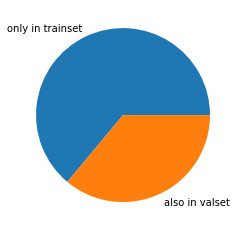

In [99]:
a = set(train_df['Y_label']) - set(val_df['Y_label']) #只有在訓練集出現
b = set(val_df['Y_label']) & set(train_df['Y_label']) #同時出現
print(len(a))
print(len(b))
print(len(a)/(len(a)+len(b)))
t = pd.DataFrame()
t['type'] = ['only in trainset' for i in range(len(a))] + ['also in valset' for i in range(len(b))]
dist = t.type.map({'only in trainset':'only in trainset', 'also in valset':'also in valset'})
dist = dist.value_counts()

plt.pie(dist,                        
        labels = t['type'].unique(),)               
plt.show()

# Model

In [73]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
model_name = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

# simple QA test

In [84]:
QA_input = {
    'question': 'What is your name?',
    'context': 'my name is Ricky'
}
res = nlp(QA_input)
QA_input['context'][res['start']:res['end']]

'Ricky'

# test model on this task before training

In [82]:
def test_model(n_test):
    i = 0
    table = pd.DataFrame()
    for _ in tqdm(range(n_test)):
        sample = df.sample(1)
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        table = table.append(row)
        i += 1
    display(table)

# bert test before fine tuning 

In [83]:
test_model(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

,label,predict:
0,ABS AG15A1-H,CIP SHENZHEN
1,BPA BISPHENOL-A,BPA BISPHENOL-A
2,POLYPROPYLENE RESIN,POLYPROPYLENE RESIN YUNGSOX 1120
3,TAIRILAC,SUPREME PETROCHEM LTD
4,EPOXY RESIN,EPOXY
5,NYLON 6 HIGH TENACITY TIRE CORD YARN,NYLON 6 HIGH TENACITY TIRE CORD
6,HDPE TAISOX 9001,HDPE TAISOX 9001
7,ETHYL ACRYLATE,ETHYL ACRYLATE
8,FR4,FR4
9,NYLON 6 HIGH TENACITY FILAMENT YARN,204600.00 KG NYLON 6
